## Imports

In [1]:
import numpy as np
import torch

## Set Random Seed

In [2]:
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

## Configuration

In [3]:
from omegaconf import OmegaConf

CONFIG = OmegaConf.create({
    # Dataset
    "num_classes": 100,
    "image_size": 32,
    "valid_transform_reprs": ["ToTensor()"],

    # Mean and std for normalization
    "normalize_mean": [0.4914, 0.4822, 0.4465],
    "normalize_std": [0.2023, 0.1994, 0.2010],

    # DataLoader
    "batch_size": 128,
    "num_workers": 8,
    "enable_pin_memory": True,

    # Model
    "model": "WideResNet-28-10-torchdistill",
    "dropout_rate": 0.3,

    # BN
    "noise_bn_option": "DARBN",

    # Checkpoint
    "checkpoint_filenames_dict": {
        # "ERM": "CIFAR10IR100__epoch_199.pt",
        # "DRS": "simclr-drs__epoch_199.pt",
        # "OPeN": "CIFAR10IR100-open__epoch_199.pt",
        "ERM": "CIFAR100IR100__epoch_199.pt",
        "DRS": "CIFAR100IR100-rs__epoch_199.pt",
        "OPeN": "CIFAR100IR100-open__epoch_199.pt",
    }
})

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Download checkpoint

In [5]:
import os
import gdown
from storage import CHECKPOINT_URLS

def download_checkpoint(checkpoint_filename):
    checkpoint_filepath = f"checkpoints/{checkpoint_filename}"
    if not os.path.exists(checkpoint_filepath):
        gdown.download(CHECKPOINT_URLS[checkpoint_filename], checkpoint_filepath, quiet=False)

    return checkpoint_filepath

## Initialize Model

In [6]:
from initializers import initialize_model, InputNormalize
from models.noise_bn_option import NoiseBnOption
from checkpointing import load_checkpoint


def get_model_and_normalizer(checkpoint_filepath):
    net = initialize_model(
        model_name=CONFIG.model, 
        num_classes=CONFIG.num_classes, 
        noise_bn_option=NoiseBnOption[CONFIG.noise_bn_option],
        dropout_rate=CONFIG.dropout_rate)
    load_checkpoint(net, optimizer=None, checkpoint_filepath=checkpoint_filepath)
    net = net.to(device)
    net = net.eval()

    normalizer = InputNormalize(
        torch.Tensor(CONFIG.normalize_mean).to(device), 
        torch.Tensor(CONFIG.normalize_std).to(device)
    ).to(device)

    return net, normalizer

## Load Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, CIFAR100

from initializers import initialize_transforms

DATA_ROOT = "./data"
valid_transform = initialize_transforms(CONFIG.valid_transform_reprs)
if CONFIG.num_classes == 10:
    valid_dataset = CIFAR10(root=DATA_ROOT, train=False, transform=valid_transform, download=True)
elif CONFIG.num_classes == 100:
    valid_dataset = CIFAR100(root=DATA_ROOT, train=False, transform=valid_transform, download=True)
else:
    raise ValueError("CONFIG.num_classes should be 10 or 100")

valid_loader = DataLoader(
    valid_dataset,
    batch_size=CONFIG.batch_size,
    num_workers=CONFIG.num_workers,
    pin_memory=CONFIG.enable_pin_memory,
)

Files already downloaded and verified


## Generate Predictions

In [8]:
def predict(net, normalizer, valid_loader):
    valid_outputs = []
    valid_labels = []
    for minibatch_i, (inputs, labels) in enumerate(valid_loader):
        inputs = inputs.float().to(device)
        labels = labels.to(device)

        with torch.no_grad():
            inputs = normalizer(inputs)
            outputs = net(inputs)

        valid_outputs.extend(outputs.cpu().detach().tolist())
        valid_labels.extend(labels.cpu().detach().tolist())

    valid_outputs = np.array(valid_outputs)
    valid_labels = np.array(valid_labels)
    valid_preds = np.argmax(valid_outputs, axis=1)

    return valid_preds, valid_labels

## Compute Group Accuracy

In [9]:
from sklearn.metrics import recall_score

def compute_group_accuracy(preds, labels):
    recalls = recall_score(
        y_true=labels,
        y_pred=preds,
        labels=np.arange(CONFIG.num_classes),
        average=None,
    )

    number_of_groups = 5    
    class_per_group = len(recalls) // number_of_groups
    group_accs = []
    for group_i in range(number_of_groups):
        group_recalls = recalls[group_i*class_per_group:(group_i+1)*class_per_group]
        group_acc = np.mean(group_recalls) * 100
        group_accs.append(group_acc)

    return group_accs[::-1]

## Run

In [10]:
group_accs_per_method = {}
for method_name, checkpoint_filename in CONFIG.checkpoint_filenames_dict.items():
    checkpoint_filepath = download_checkpoint(checkpoint_filename)
    net, normalizer = get_model_and_normalizer(checkpoint_filepath)
    preds, labels = predict(net, normalizer, valid_loader)
    group_accs = compute_group_accuracy(preds, labels)
    group_accs_per_method[method_name] = group_accs

Downloading...
From: https://drive.google.com/uc?id=1UwEt6VJklIGsG4SVNENv9aSqUfruyvIh
To: /workspace/pure-noise/checkpoints/CIFAR100IR100__epoch_199.pt
100%|██████████| 292M/292M [00:04<00:00, 61.1MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1bdsOBDmdE4rPUjnxq7hwmXVEYFsqk5dH
To: /workspace/pure-noise/checkpoints/CIFAR100IR100-rs__epoch_199.pt
100%|██████████| 292M/292M [00:06<00:00, 48.1MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1xo7ex0cIanR-FxQ8qFlKSR0fv3PdUmXk
To: /workspace/pure-noise/checkpoints/CIFAR100IR100-open__epoch_199.pt
100%|██████████| 292M/292M [00:05<00:00, 57.1MB/s] 


In [11]:
group_accs_per_method

{'ERM': [9.049999999999999,
  31.399999999999995,
  49.55000000000001,
  66.15000000000002,
  79.4],
 'DRS': [22.4, 38.65, 52.95000000000001, 65.05000000000001, 75.05000000000001],
 'OPeN': [28.1, 40.5, 55.65, 64.24999999999999, 72.09999999999998]}

## Plot

In [12]:
import seaborn as sns
sns.set()

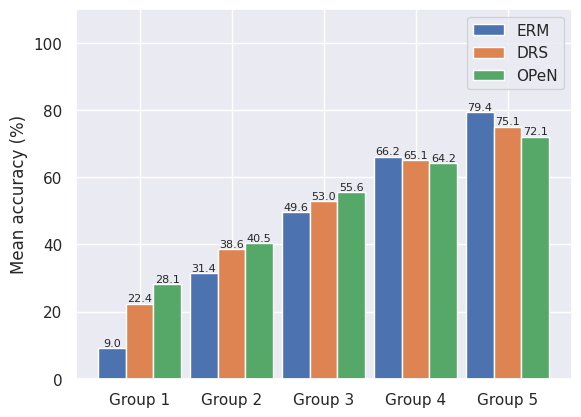

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_axis = np.arange(5)
bar_width = 0.3
bar1 = ax.bar(x_axis - bar_width, group_accs_per_method["ERM"], bar_width, label="ERM")
bar2 = ax.bar(x_axis, group_accs_per_method["DRS"], bar_width, label="DRS")
bar3 = ax.bar(x_axis + bar_width, group_accs_per_method["OPeN"], bar_width, label="OPeN")

for bar in [bar1, bar2, bar3]:
    for rect in bar:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, 1.0*height, f"{height:.1f}", ha="center", va="bottom", size=8)

ax.set_ylim(0, 110)
ax.set_xticks(x_axis, ["Group 1", "Group 2", "Group 3", "Group 4", "Group 5"])
ax.set_ylabel("Mean accuracy (%)")
ax.legend()
fig.savefig("group_accuracy.png", bbox_inches='tight')
fig.show()